## 1. Standard Import

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F
from scipy.signal import convolve2d

In [4]:
# for getting summary info on models
from torchsummary import summary

In [5]:
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

## 2. Import the data

In [6]:
# import dataset (comes with colab!)
data = pd.read_csv("Mnist_combined.csv", index_col=0)

# Sampling
#data = data.sample(20000, random_state=123)

data = data.to_numpy()

# Extracting only the first 8
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
# Although T.ToTensor() will internally do the Min-Max scaling
data = data / np.max(data)

# Reshape to 2D!
# number of images : data.shape[0]
# number of input channel : 1
# height : 28
# width :  28
data = data.reshape(data.shape[0],1,28,28)

In [7]:
# check sizes
print(data.shape)
print(labels.shape)

(70000, 1, 28, 28)
(70000,)


## 3. Create DataLoader

#### (i) convert to tensor

In [8]:
dataT   = torch.tensor( data ).float()
labelsT = torch.tensor( labels ).long()

#### (ii) Train-Test split

In [9]:
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.15)

#### (iii) Convert into PyTorch Datasets

In [10]:
train_dataset = TensorDataset(train_data,train_labels)
test_dataset  = TensorDataset(test_data,test_labels)

#### (iv) Translate into dataloader objects

In [11]:
batchsize    = 32

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=test_dataset.tensors[0].shape[0])

In [12]:
# check size (should be No. of images x No. of channels x width X height)
train_loader.dataset.tensors[0].shape

torch.Size([59500, 1, 28, 28])

In [13]:
dataT.shape

torch.Size([70000, 1, 28, 28])

In [14]:
dataT.shape.numel()

54880000

In [15]:
dataT.shape[0]

70000

In [16]:
dataT.shape.numel()/dataT.shape[0]

784.0

## 4. Create the DL model

In [17]:
# create a class for the model
def createTheMNISTNet(LR, printtoggle=False):

    class mnistNet(nn.Module):
        
        def __init__(self,printtoggle):
            super().__init__()

            ### convolution layers
            # 1:in_channels (gray scale) , 10:out_channels, stride=1 (No striding)
            self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
            # since, it's a square image, therefore row_size = column_size
            # size: np.floor( (28+2*1-5)/1 )+1 = 26/2 = 13 (/2 because maxpool)

            self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
            # size: np.floor( (13+2*1-5)/1 )+1 = 11/2 = 5 (/2 because maxpool)

            # compute the number of units in FClayer (number of outputs of conv2)
            # fc1 layer has no padding or kernel, so set to padding=0 and stride=1
            expectSize = np.floor( (5+2*0-1)/1 ) + 1 
            # Since, it's a square image, therefore num_pixels_rows = num_pixels_cols
            # otherwise, we'll have to calculate 'expectSize' for rows and columns separately
            # 20:out_channels from conv2 layer
            expectSize = 20*int(expectSize**2)
            # expectSize : indicating number if input features per image

            ### fully-connected layer
            # 50 : number of Neurons
            self.fc1 = nn.Linear(expectSize,50)

            ### output layer
            self.out = nn.Linear(50,10)

            # toggle for printing out tensor sizes during forward prop
            self.print = printtoggle

        # forward pass
        def forward(self,x):

            print(f'Input: {x.shape}') if self.print else None

            # convolution -> maxpool -> relu
            # 2 : pooling window_size
            x = F.relu( F.max_pool2d( self.conv1(x), 2) )
            print(f'Layer conv1-->pool1: {x.shape}') if self.print else None

            # and again: convolution -> maxpool -> relu
            x = F.relu( F.max_pool2d( self.conv2(x), 2) )
            print(f'Layer conv2-->pool2: {x.shape}') if self.print else None

            # reshape for linear layer
            # torch.numel(input) : Returns the total number of elements in the input tensor.
            nUnits = x.shape.numel()/x.shape[0]

            # Reshaping
            x = x.view(-1,int(nUnits))

            if self.print: print(f'Vectorize : {x.shape}')

            # linear layers
            x = F.relu( self.fc1(x) )
            if self.print: print(f'Layer fc1: {x.shape}')

            x = self.out(x)
            if self.print: print(f'Layer out: {x.shape}')

            return x
  
    # create the model instance
    model = mnistNet(printtoggle)

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr=LR)

    return model, lossfunc, optimizer

#### Testing the shapes at each layer

In [18]:
# test the model with one batch
test_net, test_lossfun, test_optimizer = createTheMNISTNet(LR=0.001,printtoggle=True)

X,y = next(iter(train_loader))
yHat = test_net(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = test_lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

# 32 : batch size

Input: torch.Size([32, 1, 28, 28])
Layer conv1-->pool1: torch.Size([32, 10, 13, 13])
Layer conv2-->pool2: torch.Size([32, 20, 5, 5])
Vectorize : torch.Size([32, 500])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss:
tensor(2.3119, grad_fn=<NllLossBackward0>)


### Learnable Parameters Calculation

#### (i) Input layer

Input layer has nothing to learn, at it’s core, what it does is just provide the input image’s shape. <br>So no learnable parameters here. 
<br>Thus number of parameters = 0.

#### (ii) Conv layer

This is where CNN learns, so certainly we’ll have weight matrices. 
<br>To calculate the learnable parameters here, all we have to do is just multiply by the ****width m, height n, previous layer’s filters d and account for all such filters k in the current layer.****
<br>Don’t forget to add the bias term for each of the filter. 
<br>Number of parameters in a CONV layer would be : <b>((m * n * d)+1)* k)</b>, added 1 because of the bias term for each filter. 

where : <br>

<b>m :</b> width of kernel in current conv layer<br>
<b>n :</b> height of kernel in current conv layer <br>
<b>d :</b> number of channels (kernels) in previous layer (i.e., input channel size )<br>
<b>k :</b> number of channels (kernels) in output of current conv layer (i.e., output channel size)<br>

#### (iii) Pool layer

This has got no learnable parameters because all it does is calculate a specific number, no backprop learning involved! 
<br>Thus number of parameters = 0.

### NOTE : 
CONV + Pooling is termed as a <b>layer.</b>

#### Using summary function of pytorch

In [19]:
# count the total number of parameters in the model

summary(test_net,(1,28,28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1-->pool1: torch.Size([2, 10, 13, 13])
Layer conv2-->pool2: torch.Size([2, 20, 5, 5])
Vectorize : torch.Size([2, 500])
Layer fc1: torch.Size([2, 50])
Layer out: torch.Size([2, 10])
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          260
├─Conv2d: 1-2                            [-1, 20, 11, 11]          5,020
├─Linear: 1-3                            [-1, 50]                  25,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
Total mult-adds (M): 0.80
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          260
├─Conv2d: 1-2                            [-1, 20, 11, 11]          5,020
├─Linear: 1-3                            [-1, 50]                  25,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
Total mult-adds (M): 0.80
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19

## 5. Model Training

In [20]:
def function2trainTheModel(Model, lossfunc, optimizer, train_loader, test_loader, epochs):

    losses   = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
        # Batch Training
        for X,y in train_loader:

            # Forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_test = Model(X)
      
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round(100*torch.mean((torch.argmax(yHat_test,axis=1)==y).float()),2 ) )
        # End epochs

    # function output
    return trainAcc,testAcc,losses,Model

## 6.  Run the model 

In [21]:
CNN_model,lossfunc,optimizer = createTheMNISTNet(LR=0.001, printtoggle=False)

In [22]:
# took 15mins 
TrainAcc,TestAcc,Losses,trained_Model=function2trainTheModel(Model=CNN_model , 
                                                             lossfunc=lossfunc , 
                                                             optimizer=optimizer,
                                                             train_loader=train_loader , 
                                                             test_loader=test_loader, 
                                                             epochs=25)

## 7. Results Visualization

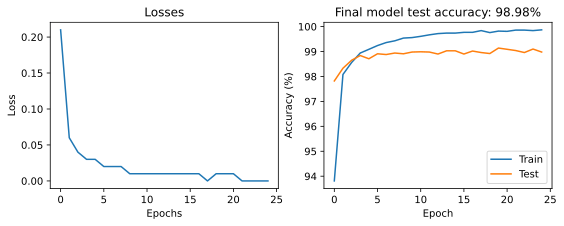

In [23]:
fig,ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(Losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses')

ax[1].plot(TrainAcc,label='Train')
ax[1].plot(TestAcc, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'Final model test accuracy: {TestAcc[-1]:.2f}%')
ax[1].legend()

plt.show()